In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import bemcs

# Function to label open nodes, overlapping interior nodes and triple junctions automatically
def label_nodes(els):
    n_els = len(els.x1)
    # first find all unique points
    points = np.zeros((2 * n_els, 2))
    x1y1 = np.vstack((els.x1, els.y1)).T
    x2y2 = np.vstack((els.x2, els.y2)).T
    points[0::2, :] = x1y1
    points[1::2, :] = x2y2
    nvec = np.vstack((els.x_normals, els.y_normals)).T
    xmid = np.copy(els.x_centers)
    ymid = np.copy(els.y_centers)
    unique_points, id_unique = np.unique(points, axis=0, return_index=True)

    # Find number of open, 2-overlap & triple junction nodes
    index_matrix1 = []
    index_matrix2 = []
    index_matrix3 = []
    for i in range(len(unique_points)):
        pts = unique_points[i, :].reshape(1, -1)

        # Which element(s) contains this point
        id1 = np.where(np.all(pts == x1y1, axis=1))
        id2 = np.where(np.all(pts == x2y2, axis=1))

        # The negative signs are for the triple junction equations
        # s_1 + s_2 + s_3 = 0 with the negative sign going to any 2 elements that are both id1 or id2
        if np.size(id1) == 2:
            id_combo = np.hstack((-id1[0] * 3, id2[0] * 3 + 2))
        elif np.size(id2) == 2:
            id_combo = np.hstack((id1[0] * 3, -(id2[0] * 3 + 2)))
        else:
            id_combo = np.hstack((id1[0] * 3, id2[0] * 3 + 2))

        if np.size(id_combo) == 1:
            index_matrix1.append(id_combo)
        elif np.size(id_combo) == 2:
            index_matrix2.append(id_combo)
        elif np.size(id_combo) == 3:
            index_matrix3.append(id_combo)
        else:
            print(id_combo)
            raise ValueError("Cannot deal with more than 3 lines at a node")

    print("Number of open nodes =", len(index_matrix1))
    print(":", index_matrix1)
    print("Number of 2-overlap nodes =", len(index_matrix2))
    print(":", index_matrix2)
    print("Number of triple junctions =", len(index_matrix3))
    print(":", index_matrix3)

    return index_matrix1, index_matrix2, index_matrix3

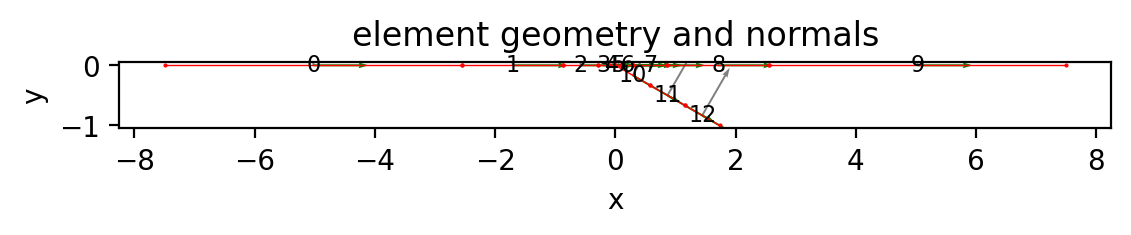

In [2]:
# Elastic parameters
mu = 1
nu = 0.25

# Create fault and topography mesh
# create a mesh of topography
topo_n = 10  # only even number
topo_L = 15  # topo extent in x from [-L/2,L/2]
topo_amp = 0  # amplitude of topography as a Gaussian
topo_sigma = 1  # spread of Gaussian topography

xlogvals = np.logspace(-1.0, np.log10(topo_L / 2), int(topo_n / 2))
xmesh = np.concatenate((-xlogvals[::-1], [0.0], xlogvals))
xt1 = xmesh[0:-1]
xt2 = xmesh[1:]
yt1 = topo_amp * np.exp(-(xt1**2) / 2 / (topo_sigma**2))
yt2 = topo_amp * np.exp(-(xt2**2) / 2 / (topo_sigma**2))

# create a mesh of a dipping fault intersecting the free surface
fault_n = 3
slipvalues_x = np.random.normal(0, 1, fault_n)
slipvalues_y = np.random.normal(0, 1, fault_n)

fault_L = 2.0
fault_dip = 30 * np.pi / 180
# Sinusoidal y-positions for fault elements
xlocs = np.linspace(0, fault_L * np.cos(fault_dip), fault_n + 1)
ylocs = -np.linspace(0, fault_L * np.sin(fault_dip), fault_n + 1)

# Wavy fault geometry
xf1 = xlocs[0:-1]
xf2 = xlocs[1:]
yf1 = ylocs[0:-1]
yf2 = ylocs[1:]

# create bemcs data structure
els = bemcs.initialize_els()
els.x1 = np.concatenate([xt1, xf1])
els.y1 = np.concatenate([yt1, yf1])
els.x2 = np.concatenate([xt2, xf2])
els.y2 = np.concatenate([yt2, yf2])
bemcs.standardize_els_geometry(els)
n_els = len(els.x1)
bemcs.plot_els_geometry(els)

## Identifying open nodes, overlapping interior nodes and triple junctions automatically

In [3]:
index_open, index_overlap, index_triple = label_nodes(els)
N_c = 2 * n_els  # central node equations
N_o = 2 * len(index_open)  # open node equations
N_i = 4 * len(index_overlap)  # overlapping node equations
N_t = 6 * len(index_triple)  # triple junction equations

Number of open nodes = 3
: [array([0]), array([38]), array([29])]
Number of 2-overlap nodes = 10
: [array([3, 2]), array([6, 5]), array([9, 8]), array([12, 11]), array([18, 17]), array([21, 20]), array([33, 32]), array([24, 23]), array([36, 35]), array([27, 26])]
Number of triple junctions = 1
: [array([-15, -30,  14])]


In [4]:
Nequations = N_c + N_o + N_i + N_t
Nunknowns = 6 * n_els

# We will stack this with
# equations for the element centers
# equations at open nodes (RHS = 0)
# equations at overlapping nodes (RHS = 0)
# equations at triple junctions (RHS = 0)
BC_c = np.zeros((N_c, 1))  # these are the only non-zero entries
BC_o = np.zeros((N_o, 1))
BC_i = np.zeros((N_i, 1))
BC_t = np.zeros((N_t, 1))

# Boundary conditions are
# topography - traction-free (tx,ty) = (0,0)
# fault mesh - specified slip values
bc_x = np.zeros((n_els, 1))
bc_y = np.zeros((n_els, 1))
# logical index for topography mesh in 'els'
topo_index = np.zeros(n_els, dtype=bool)
topo_index[0:topo_n] = True

bc_x[topo_index, 0] = 0.0
bc_y[topo_index, 0] = 0.0
bc_x[~topo_index, 0] = slipvalues_x
bc_y[~topo_index, 0] = slipvalues_y

BC_c[0::2] = bc_x
BC_c[1::2] = bc_y
# stack all the BCs into 1 big vector
BCvector = np.vstack((BC_c, BC_o, BC_i, BC_t))

## Design Matrix System 
- At element centers, we implement either displacement or traction boundary conditions
- At open nodes, we force slip to be 0
- At 2-overlap (interior) nodes we have continuity & smoothness of slip
- At triple junctions, we implement 2 equations for conservation of slip and 4 equations for smoothness

We first deal with the matrix system for the central nodes

In [5]:
# Design matrices (in x,y coordinates) for slip and slip gradients at each 3qn
matrix_slip, matrix_slip_gradient = bemcs.get_matrices_slip_slip_gradient(els)

# Patch center locations (need to be shifted an infinitesimal amount in -ve unit normal direction)
obs_xy = np.vstack((els.x_centers, els.y_centers)).T
x_obs = obs_xy[:, 0].reshape(-1, 1)
y_obs = obs_xy[:, 1].reshape(-1, 1)

# Compute shear and tensile stress kernels evaluated ONLY at the center of each element
kernels_s = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "shear")
kernels_n = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "normal")

# Convert to traction kernels [Nobs x Ncoefficients]
traction_kernels_s = bemcs.get_traction_kernels(els, kernels_s, flag="global")
traction_kernels_n = bemcs.get_traction_kernels(els, kernels_n, flag="global")

# Linear Operators for the appropriate boundary conditions
matrix_system_c = np.zeros((N_c, Nunknowns))
matrix_system_o = np.zeros((N_o, Nunknowns))
matrix_system_i = np.zeros((N_i, Nunknowns))
matrix_system_t = np.zeros((N_t, Nunknowns))

# Linear operator for central node BCs
kerneleval_x = np.zeros((n_els, Nunknowns))
kerneleval_y = np.zeros((n_els, Nunknowns))

# x-kernels
kerneleval_x[topo_index, 0::6] = traction_kernels_s[0][topo_index, 0::3]
kerneleval_x[topo_index, 1::6] = traction_kernels_s[0][topo_index, 1::3]
kerneleval_x[topo_index, 2::6] = traction_kernels_s[0][topo_index, 2::3]
kerneleval_x[topo_index, 3::6] = traction_kernels_n[0][topo_index, 0::3]
kerneleval_x[topo_index, 4::6] = traction_kernels_n[0][topo_index, 1::3]
kerneleval_x[topo_index, 5::6] = traction_kernels_n[0][topo_index, 2::3]
kerneleval_x[~topo_index, :] = matrix_slip[2::6, :][~topo_index, :]

# y-kernels
kerneleval_y[topo_index, 0::6] = traction_kernels_s[1][topo_index, 0::3]
kerneleval_y[topo_index, 1::6] = traction_kernels_s[1][topo_index, 1::3]
kerneleval_y[topo_index, 2::6] = traction_kernels_s[1][topo_index, 2::3]
kerneleval_y[topo_index, 3::6] = traction_kernels_n[1][topo_index, 0::3]
kerneleval_y[topo_index, 4::6] = traction_kernels_n[1][topo_index, 1::3]
kerneleval_y[topo_index, 5::6] = traction_kernels_n[1][topo_index, 2::3]
kerneleval_y[~topo_index, :] = matrix_slip[3::6, :][~topo_index, :]

# populate matrix_system for central nodes
matrix_system_c[0::2, :] = kerneleval_x
matrix_system_c[1::2, :] = kerneleval_y

/Users/mallickrishg/Dropbox/scripts/Pythoncode/bemcs/bemcs/bemcs.py:149: RuntimeWarning: divide by zero encountered in divide
  arctan_x_plus_a = np.pi / 2 * np.sign(y / (a + x)) - np.arctan(y / (a + x))


### Open nodes, overlapping nodes & triple junctions

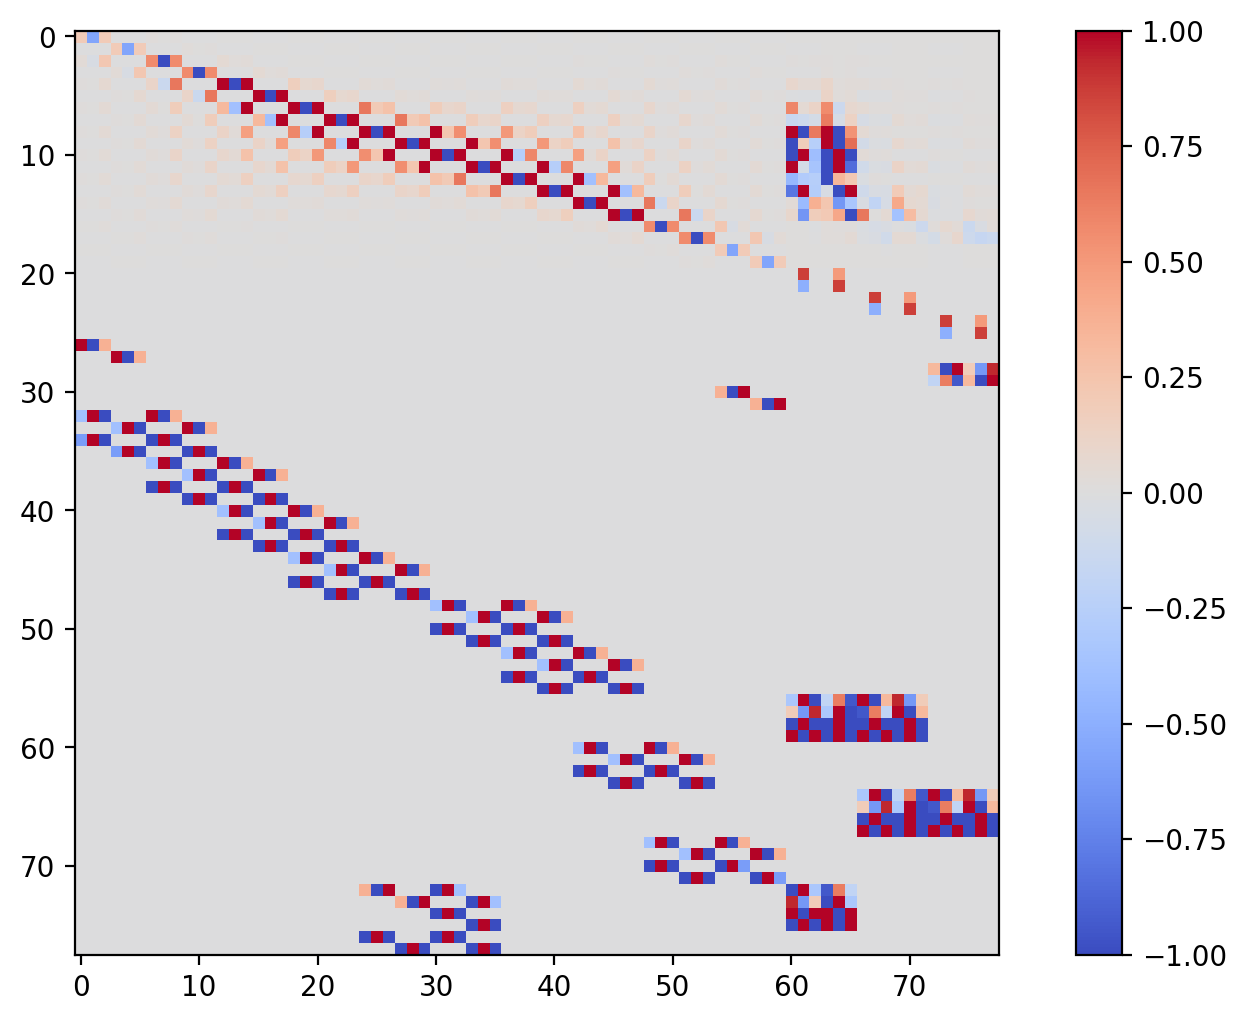

In [6]:
# Linear operator for open nodes
for i in range(int(N_o / 2)):
    id1 = index_open[i]  # node number
    matrix_system_o[2 * i, :] = matrix_slip[2 * id1, :]  # x component
    matrix_system_o[2 * i + 1, :] = matrix_slip[2 * id1 + 1, :]  # y component

# Linear operator for overlapping nodes
for i in range(int(N_i / 4)):
    idvals = index_overlap[i]  # node number
    # continuity condition
    matrix_system_i[4 * i, :] = (
        matrix_slip[2 * idvals[0], :] - matrix_slip[2 * idvals[1], :]
    )  # x
    matrix_system_i[4 * i + 1, :] = (
        matrix_slip[2 * idvals[0] + 1, :] - matrix_slip[2 * idvals[1] + 1, :]
    )  # y
    # smoothing constraints
    matrix_system_i[4 * i + 2, :] = (
        matrix_slip_gradient[2 * idvals[0], :] - matrix_slip_gradient[2 * idvals[1], :]
    )  # x
    matrix_system_i[4 * i + 3, :] = (
        matrix_slip_gradient[2 * idvals[0] + 1, :]
        - matrix_slip_gradient[2 * idvals[1] + 1, :]
    )  # y

# Linear operator for triple junction nodes
for i in range(int(N_t / 6)):
    id1 = index_triple[i]
    idvals = np.abs(id1)

    id_neg = idvals[id1 < 0]  # node number that need to be subtracted in TJ kinematics
    id_pos = idvals[id1 >= 0]  # node numbers that need to be added
    # triple junction kinematics equations
    if len(id_neg) == 2:
        matrix_system_t[6 * i, :] = (
            matrix_slip[2 * id_pos, :]
            - matrix_slip[2 * id_neg[0], :]
            - matrix_slip[2 * id_neg[1], :]
        )  # x component
        matrix_system_t[6 * i + 1, :] = (
            matrix_slip[2 * id_pos + 1, :]
            - matrix_slip[2 * id_neg[0] + 1, :]
            - matrix_slip[2 * id_neg[1] + 1, :]
        )  # y component
    else:
        matrix_system_t[6 * i, :] = (
            matrix_slip[2 * id_pos[0], :]
            + matrix_slip[2 * id_pos[1], :]
            - matrix_slip[2 * id_neg, :]
        )  # x component
        matrix_system_t[6 * i + 1, :] = (
            matrix_slip[2 * id_pos[0] + 1, :]
            + matrix_slip[2 * id_pos[1] + 1, :]
            - matrix_slip[2 * id_neg + 1, :]
        )  # y component

    # smoothing constraints (2 nodes at a time)
    matrix_system_t[6 * i + 2, :] = (
        matrix_slip_gradient[2 * idvals[0], :] - matrix_slip_gradient[2 * idvals[1], :]
    )  # x
    matrix_system_t[6 * i + 3, :] = (
        matrix_slip_gradient[2 * idvals[0] + 1, :]
        - matrix_slip_gradient[2 * idvals[1] + 1, :]
    )  # y
    matrix_system_t[6 * i + 4, :] = (
        matrix_slip_gradient[2 * idvals[0], :] - matrix_slip_gradient[2 * idvals[2], :]
    )  # x
    matrix_system_t[6 * i + 5, :] = (
        matrix_slip_gradient[2 * idvals[0] + 1, :]
        - matrix_slip_gradient[2 * idvals[2] + 1, :]
    )  # y

# stack the matrices and create the full linear operator
matrix_system = np.vstack(
    (matrix_system_c, matrix_system_o, matrix_system_i, matrix_system_t)
)

# plot design matrix
plt.figure(figsize=(10, 6))
plt.imshow(matrix_system, cmap="coolwarm")
plt.colorbar()
plt.clim(-1, 1)
plt.show()